In [1]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

In [2]:
dataset = pd.read_csv('daily-bike-share.csv')
dataset

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,01/01/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,01/02/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,01/03/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,01/04/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,01/05/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,12/27/2012,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247
727,728,12/28/2012,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644
728,729,12/29/2012,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159
729,730,12/30/2012,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364


In [3]:
dataset.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000


To change this task into a classification ML, I will create a new column: whether or not the company profits on that day from the bike rentals. Lets use 700 rentals a day, which is around the median value, as a profit freshold and set a value 0 or 1 for "lost money" and "profitted".

In [4]:
def profit(x):
    if x < 700:
        return 0
    else:
        return 1
dataset["profit"] = dataset["rentals"].apply(lambda x: profit(x))
dataset.sample(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals,profit
393,394,1/29/2012,1,1,1,0,0,0,1,0.282500,0.272721,0.311250,0.240050,558,0
3,4,01/04/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,0
261,262,9/19/2011,3,0,9,0,1,1,2,0.549167,0.529675,0.690000,0.151742,691,0
169,170,6/19/2011,2,0,6,0,0,0,2,0.699167,0.645846,0.666667,0.102000,1639,1
708,709,12/09/2012,4,1,12,0,0,0,2,0.384167,0.390146,0.905417,0.157975,441,0
560,561,7/14/2012,3,1,7,0,6,0,2,0.703333,0.666042,0.699167,0.143679,2355,1
534,535,6/18/2012,2,1,6,0,1,1,2,0.568333,0.544842,0.777917,0.174746,653,0
455,456,3/31/2012,2,1,3,0,6,0,2,0.424167,0.421708,0.738333,0.250617,2301,1
103,104,4/14/2011,2,0,4,0,4,1,1,0.467500,0.462742,0.540417,0.110700,529,0
427,428,03/03/2012,1,1,3,0,6,0,2,0.414167,0.413492,0.621250,0.161079,956,1


In [5]:
X = dataset.drop(['profit'], axis=1).copy()
y = dataset['profit'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [6]:
num_features = ["temp","atemp","hum","windspeed"]
cat_features = ["season","yr","mnth","holiday","weekday","workingday","weathersit"]

In [7]:
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])
print('Raw dataset - Training set:')
print(X_train[num_features].isnull().mean())
X_train_trasnformed = num_preparation.fit_transform(X_train[num_features])
X_train_trasnformed = pd.DataFrame(X_train_trasnformed, columns=num_features)
print('\nPipeline - Training set')
print(X_train_trasnformed[num_features].isnull().mean())

Raw dataset - Training set:
temp         0.0
atemp        0.0
hum          0.0
windspeed    0.0
dtype: float64

Pipeline - Training set
temp         0.0
atemp        0.0
hum          0.0
windspeed    0.0
dtype: float64


In [8]:
print('Raw dataset - Testing set:')
print(X_test[num_features].isnull().mean())
X_test_trasnformed = num_preparation.transform(X_test[num_features])
X_test_trasnformed = pd.DataFrame(X_test_trasnformed, columns=num_features)
print('\nPipeline - Testing set')
print(X_test_trasnformed[num_features].isnull().mean())

Raw dataset - Testing set:
temp         0.0
atemp        0.0
hum          0.0
windspeed    0.0
dtype: float64

Pipeline - Testing set
temp         0.0
atemp        0.0
hum          0.0
windspeed    0.0
dtype: float64


In [9]:
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])
data_preparation.fit_transform(X_train)

array([[0.441667, 0.440642, 0.624583, 0.22575 ],
       [0.805833, 0.729796, 0.480833, 0.164813],
       [0.463333, 0.457038, 0.569167, 0.167912],
       ...,
       [0.336667, 0.321954, 0.729583, 0.219521],
       [0.353333, 0.338363, 0.596667, 0.296037],
       [0.68    , 0.635556, 0.85    , 0.375617]])

In [10]:
data_preparation.fit_transform(X_train).shape

(548, 4)

In [17]:
cat_preparation = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse_output=False ,handle_unknown='ignore'))
])
cat_preparation.fit_transform(X_train[cat_features])

array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [18]:
cat_preparation.fit_transform(X_train[cat_features]).shape

(548, 32)

In [14]:
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])
data_preparation.fit_transform(X_train)
data_preparation.fit_transform(X_train).shape

(548, 36)

In [19]:
model_pipeline_v1 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline_v1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer())]),
                                                  ['temp', 'atemp', 'hum',
                                                   'windspeed']),
                                                 ('categorical_preprocessing',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['season', 'yr', 'mnth',
                                                   'holiday', 'weekday',
                                                   'workingday',
                                                   'weathersit'])])),
                ('model', LogisticRegression(max_iter=10000))])

              precision    recall  f1-score   support

           0       0.87      0.92      0.90        90
           1       0.92      0.87      0.90        93

    accuracy                           0.90       183
   macro avg       0.90      0.90      0.90       183
weighted avg       0.90      0.90      0.90       183



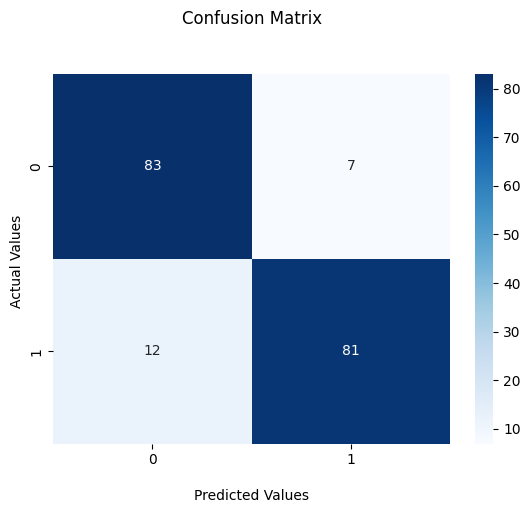

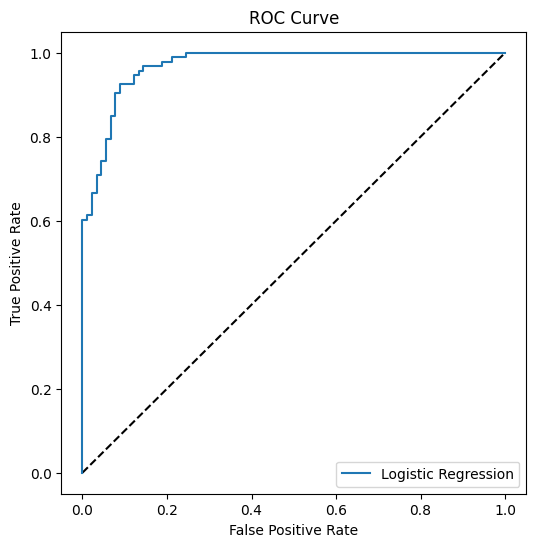

C:\Users\Michal Krzyzanowski\AppData\Local\Temp\ipykernel_18240\3558387898.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_dataframe = pd.concat([metrics_dataframe, new_metrics], ignore_index=True)


,Model,F1_score,AUC
0,Logistic Regression,0.895028,0.970609


In [20]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    print(classification_report(y_checked, predictions))

    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    new_metrics = pd.DataFrame({'Model': [name], 'F1_score': [f1_metric], 'AUC': [auc_metric]})
    metrics_dataframe = pd.concat([metrics_dataframe, new_metrics], ignore_index=True)
    return metrics_dataframe

calculate_metrics(model_pipeline_v1, 'Logistic Regression', X_test, y_test)

In [22]:
num_features = ["temp","atemp","hum","windspeed"]
cat_features = ["season","yr","mnth","holiday","weekday","workingday","weathersit"]

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean')),
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

# przygotowanie wartości kategorycznych
cat_preparation = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse_output=False ,handle_unknown='ignore'))
])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features),
    ('categorical_preprocessing', cat_preparation, cat_features)
])

model_pipeline_v2 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline_v2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['temp', 'atemp', 'hum',
                                                   'windspeed']),
                                                 ('categorical_preprocessing',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['season', 'yr', 'mnth',
                                                   'holiday', 'weekday',
                                                   'workingday',
                                                   'weathersit'])])),
                ('model', LogisticRegression(max_iter=10000))])

              precision    recall  f1-score   support

           0       0.90      0.94      0.92        90
           1       0.94      0.90      0.92        93

    accuracy                           0.92       183
   macro avg       0.92      0.92      0.92       183
weighted avg       0.92      0.92      0.92       183



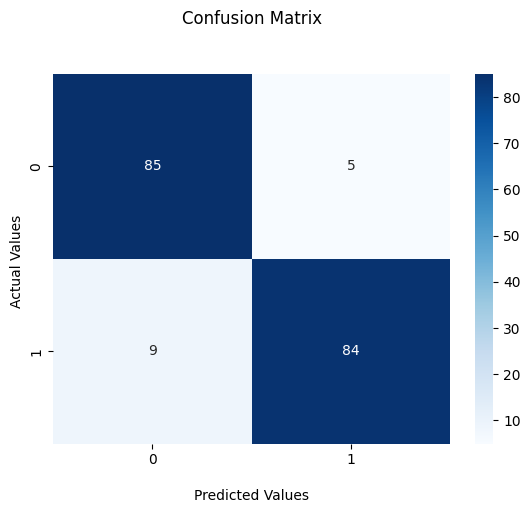

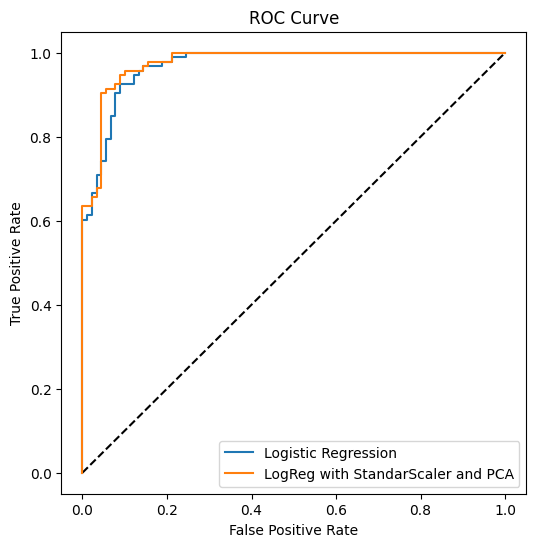

,Model,F1_score,AUC
0,Logistic Regression,0.895028,0.970609
1,LogReg with StandarScaler and PCA,0.923077,0.976583


In [23]:
calculate_metrics(model_pipeline_v2, 'LogReg with StandarScaler and PCA', X_test, y_test)

In [24]:
model_pipeline_v3 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000))])
list(model_pipeline_v3.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__numeric_preprocessing',
 'preprocessor__categorical_preprocessing',
 'preprocessor__numeric_preprocessing__memory',
 'preprocessor__numeric_preprocessing__steps',
 'preprocessor__numeric_preprocessing__verbose',
 'preprocessor__numeric_preprocessing__fill_missings',
 'preprocessor__numeric_preprocessing__polynomial_features',
 'preprocessor__numeric_preprocessing__scaler_1',
 'preprocessor__numeric_preprocessing__pca',
 'preprocessor__numeric_preprocessing__scaler_2',
 'preprocessor__numeric_preprocessing__fill_missings__add_indicator',
 'preprocessor__numeric_preprocessing__fill_missings__copy',
 'preprocessor__numeric_preprocessing__fill_missings__fill_value',
 'preprocessor__numeric_pr

In [25]:
params = {
    'preprocessor__numeric_preprocessing__polynomial_features__degree': [1, 2, 3, 4],
    'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.90, 0.95, 0.99, 0.99999],
    'model__C': np.logspace(-4, 4, 50)
}

grid_search = GridSearchCV(model_pipeline_v3, params, cv=10, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Chosen Hyperparameters: ', grid_search.best_params_)
model_v3 = grid_search.best_estimator_

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
Chosen Hyperparameters:  {'model__C': 5.428675439323859, 'preprocessor__numeric_preprocessing__pca__n_components': 0.99999, 'preprocessor__numeric_preprocessing__polynomial_features__degree': 2}


              precision    recall  f1-score   support

           0       0.93      0.91      0.92        90
           1       0.92      0.94      0.93        93

    accuracy                           0.92       183
   macro avg       0.92      0.92      0.92       183
weighted avg       0.92      0.92      0.92       183



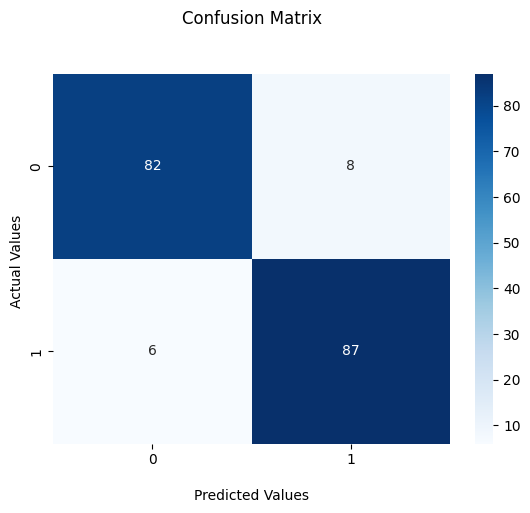

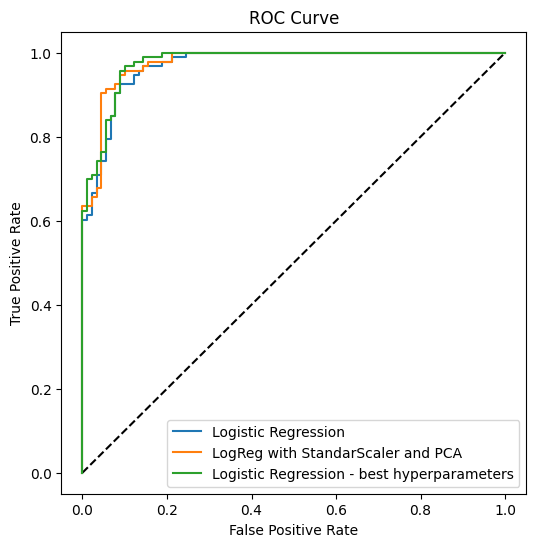

,Model,F1_score,AUC
0,Logistic Regression,0.895028,0.970609
1,LogReg with StandarScaler and PCA,0.923077,0.976583
2,Logistic Regression - best hyperparameters,0.925532,0.977061


In [26]:
calculate_metrics(model_v3, 'Logistic Regression - best hyperparameters', X_test, y_test)